# HINMINE

HINMINE [[1]](#fn1) (Heterogeneous Information Network Mining with Information Retrieval Heuristics) is a methodology for *decomposition* of heterogeneous information networks, e.g. networks consisting of multiple node and edge types. HINMINE operates on heterogeneous information networks (HINs). Formally, HINs can be defined as typed graphs as follows:

$\textrm{HIN} = (N, E, N_t, E_t),$

where $N$ is the set of nodes, $E$ the set of edges, $N_t$ the set of node types (each element of $N$ gets assigned a type from $N_t$) and edge types $E_t$ (each edge is assigned a type from $E_t$). The key idea of HINMINE can be summarised in the following two steps:
1. Network decomposition
2. Propositionalization

The first point (1.) attempts to simplify the initial $\textrm{HIN}$ into a graph $G = (N, E, w)$, where $w$ is a set of real-valued weights assigned to each edge from $E$ (one weight per edge). HINMINE achieves such decomposition by first selecting types of *meta paths* that shall be used for decomposition. Such paths are counted with respect to the number of times they link a given pair of nodes of interest, and aggregated.
More formally, given a heuristic function $f$, a weight of an edge between the two nodes $u$ and $v$ is computed as
$$ w(u,v) = \sum_{ \substack {m \in M \\ (u, m)\in E\\ (m, v)\in E}} f(m) $$


---
<span id="fn1"> [1] Kralj, J., Robnik-Šikonja, M. and Lavrač, N. HINMINE: heterogeneous information network mining with information retrieval heuristics. J Intell Inf Syst 50, 29–61 (2018). </span>

---

## Movie genre classification

In the following usecase, we will demonstrate how HINMINE can be adopted for the task of movie genre classification from a heterogeneous information network of movie actors, directors and movies. First of all, we need to ensure that all the required libraries are available. The `-q` parameter is used to suppress long installation reports produced by `pip`.

In [1]:
!pip -q install py3plex==0.83
!pip -q install pandas==1.1.4
!pip -q install seaborn==0.11.0
!pip -q install tqdm==4.54.1
!pip -q install scikit-learn==0.23.2

Let's explore possible decomposition cycles (meta-paths used during counting). We download the [IMDB dataset](https://github.com/SkBlaz/py3plex/blob/master/datasets/imdb.gpickle) into a local folder `data`, load it and begin the exploration. The dataset is stored as a pickled [`networkx.MultiDiGraph` object](https://networkx.org/documentation/stable/reference/classes/multidigraph.html).

Obtaining the IMDB data set.
Constructing a py3plex network object.
Parsing gpickle..
-------------------- 
 Computing core stats of the network 
 --------------------
Name: 
Type: MultiDiGraph
Number of nodes: 6384
Number of edges: 14592
Average in degree:   2.2857
Average out degree:   2.2857
Number of unique node IDs: 6342


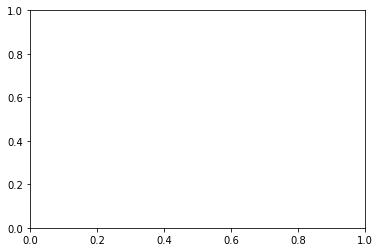

In [2]:
from urllib.request import urlopen
from py3plex.core import multinet
import warnings
warnings.filterwarnings('ignore')

print("Obtaining the IMDB data set.")
data = urlopen('https://github.com/SkBlaz/py3plex/raw/master/datasets/imdb.gpickle')
with open('data/imdb.gpickle', 'wb') as fp:
    fp.write(data.read())

dataset = "data/imdb.gpickle"

print("Constructing a py3plex network object.")
# Construct a heterogeneous information network object
multilayer_network = multinet.multi_layer_network().load_network(
    input_file=dataset, directed=True, input_type=dataset.split(".")[-1])

# Show some basic statistics
multilayer_network.basic_stats()

Let's explore how edges look like in such a network. Each edge is composed of three main parts: node 1, node 2 and edge data. Note that nodes are in fact tuples `(id, type)`. In edge data, you can see that e.g., _acts_in_ and _features_ are two possible edge types.

In [3]:
first_edges = list(multilayer_network.get_edges(data=True))[0:10]
for edge in first_edges:
    print(edge)

(('ruthay', 'person'), ('movie_81', 'movie'), {'type': 'acts_in'})
(('movie_81', 'movie'), ('buddy_guy', 'person'), {'type': 'features'})
(('movie_81', 'movie'), ('william_denis', 'person'), {'type': 'features'})
(('movie_81', 'movie'), ('marshall_bell', 'person'), {'type': 'features'})
(('movie_81', 'movie'), ('chuck_bacino', 'person'), {'type': 'features'})
(('movie_81', 'movie'), ('jacob_berenger', 'person'), {'type': 'features'})
(('movie_81', 'movie'), ('fairuza_balk', 'person'), {'type': 'features'})
(('movie_81', 'movie'), ('michael_nicolosi', 'person'), {'type': 'features'})
(('movie_81', 'movie'), ('seymour_cassel', 'person'), {'type': 'features'})
(('movie_81', 'movie'), ('phil_boardman', 'person'), {'type': 'features'})


These were some examples of links. However, how are the nodes represented? Let's inspect the printout of a couple of examples next.

In [4]:
first_nodes = list(multilayer_network.get_nodes(data=True))[0:10]
for node in first_nodes:
    print(node)

(('ruthay', 'person'), {'type': 'person'})
(('movie_81', 'movie'), {'labels': 'Crime---Drama---Romance', 'type': 'movie', 'name': 'movie_things-to-do-in-denver-when-youre-dead'})
(('riwia_brown', 'person'), {'type': 'person'})
(('movie_290', 'movie'), {'labels': 'Crime---Drama', 'type': 'movie', 'name': 'movie_once-were-warriors'})
(('peter_brocco', 'person'), {'type': 'person'})
(('movie_189', 'movie'), {'labels': 'Comedy---Fantasy', 'type': 'movie', 'name': 'movie_the-reckless-moment'})
(('charles_s_dutton', 'person'), {'type': 'person'})
(('movie_89', 'movie'), {'labels': 'Action---Thriller', 'type': 'movie', 'name': 'movie_nick-of-time'})
(('movie_40', 'movie'), {'labels': 'Drama', 'type': 'movie', 'name': 'movie_cry-the-beloved-country'})
(('niall_obrien', 'person'), {'type': 'person'})


Each node is a tuple `(name, type)`, equipped with some additional information. Note that the _labels_ attribute is present only for the _movie_ type of nodes. The "---" delimiter separates multiple possible labels that can be assigned to an individual movie. The goal will be to learn to predict these labels.

Let's try to visualize this network next. We have two main types of nodes: humans (green) and movies (red). We are interested in obtaining only the network consisting of red nodes by accounting for the green ones.

Beginning parsing..
Using custom init positions!


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


BarnesHut Approximation  took  0.82  seconds
Repulsion forces  took  12.59  seconds
Gravitational forces  took  0.04  seconds
Attraction forces  took  0.16  seconds
AdjustSpeedAndApplyForces step  took  0.15  seconds


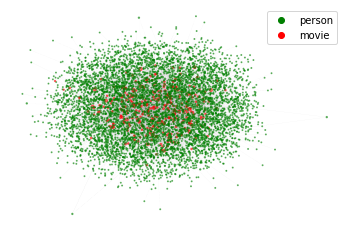

In [15]:
from py3plex.visualization.multilayer import hairball_plot
import numpy as np

hairball_plot(multilayer_network.core_network,
              layout_parameters = {"iterations": 5},
              scale_by_size = True,
              legend = True,
              layout_algorithm = "force")

Let's identify possible decomposition cycles. These are just paths connecting the target node pairs, which are in this case the "movie" types. HINMINE finds four relevant decomposition paths.

In [16]:
triplet_set = list(set(multilayer_network.get_decomposition_cycles()))
print("\n".join(triplet_set))

movie_____features_____person_____acts_in_____movie
movie_____directed_by_____person_____acts_in_____movie
movie_____directed_by_____person_____directed_____movie
movie_____features_____person_____directed_____movie


We use decomposition paths to obtain a frequency-weighted network of movies.

In [19]:
## Get the decomposition. For other heuristics, see the HINMINE paper.
decomposition = list(multilayer_network.get_decomposition(heuristic=["tf"], cycle = triplet_set))[0]

## The obtained structure is a sparse matrix.
print(decomposition)

mweight = round(np.max(decomposition[0]))

print(f"\nMaximum weight present is {mweight}")

Successfully decomposed: tf
(<297x297 sparse matrix of type '<class 'numpy.float64'>'
	with 3281 stored elements in Compressed Sparse Row format>, array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'tf')

Maximum weight present is 34


The obtained decomposition is a *homogeneous network*. This means that all existing machinery, suitable for working with this type of networks is now possible to use. Kralj et al. [[1]](#fn1) exploited the Personalized PageRank algorithm for learning node representations. Here, a personalized PageRank vector is computed for each node, and *concatenated* to obtain the final representation. Note that this representation serves the same purpose as e.g., node2vec vectors.

In [8]:
# We first import some additional functionality from the py3plex library (and sklearn, which was installed as part of py3plex!)
from py3plex.algorithms.network_classification import PPR

# The decomposed matrix is the 0-th element
decomposed_network = decomposition[0]

# The labels are the first element (multilabel classification -> one movie multiple possible genres)
labels = decomposition[1]

# compute personalized PageRank vectors for each movie.
vectors = PPR.construct_PPR_matrix(decomposed_network)

# This must be a dense matrix!
print(vectors)

[[0.         0.05099809 0.00278758 ... 0.0029905  0.0150286  0.0014722 ]
 [0.02219235 0.         0.00419921 ... 0.00165601 0.02839547 0.00205116]
 [0.00815168 0.02821877 0.         ... 0.00067962 0.0092428  0.00107619]
 ...
 [0.01296204 0.01649483 0.00100736 ... 0.         0.00603935 0.00050871]
 [0.01349753 0.0586053  0.00283872 ... 0.00125138 0.         0.00334351]
 [0.00675068 0.02161365 0.00168752 ... 0.00053815 0.01707043 0.        ]]


The obtained dense matrix can be used for down-stream learning. Let's classify the first genre with the SVM.

In [9]:
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import cross_val_score

## target space
Y = labels[:,0]
clf = SVC() # Let's use default SVM learner.
cross_val_scores = cross_val_score(clf, vectors, Y, cv=10, scoring = "accuracy")
print("The SVM scored with {} +-({})".format(np.mean(cross_val_scores), np.std(cross_val_scores)))

The SVM scored with 0.855287356321839 +-(0.01449780280481359)


What about other heuristics?

In [10]:
## Let's make an evaluation function
import pandas as pd
import seaborn as sns
import tqdm
from sklearn.multiclass import OneVsRestClassifier

def get_evaluated_heuristic(network, heuristic_name):
    
    decomposition = list(multilayer_network.get_decomposition(heuristic=[heuristic_name], cycle = triplet_set))[0]
    
    # The decomposed matrix is the 0-th element
    decomposed_network = decomposition[0]

    # The labels are the first element (multilabel classification -> one movie multiple possible genres)
    labels = decomposition[1]

    # compute personalized PageRank vectors for each movie.
    vectors = PPR.construct_PPR_matrix(decomposed_network)
    
    # target space
    Y = labels[:,:]
    
    # classifier OVR in this case
    clf = OneVsRestClassifier(SVC()) # Let's use default SVM learner.
    
    # get the score
    cross_val_scores = cross_val_score(clf, vectors, Y, cv=10, scoring = "accuracy")
    
    return np.mean(cross_val_scores)

heuristic_results = []
for repetition in tqdm.tqdm(range(5)):
    for heuristic in ["idf", "tf", "chi", "ig", "gr", "delta", "rf", "okapi"]:
        score = get_evaluated_heuristic(multilayer_network, heuristic);
        heuristic_results.append([heuristic, score])
    
final_dataframe = pd.DataFrame(heuristic_results)
final_dataframe.columns = ['Heuristic','Accuracy']

  0%|          | 0/5 [00:00<?, ?it/s]

Successfully decomposed: idf
Successfully decomposed: tf
Successfully decomposed: chi
Successfully decomposed: ig
Successfully decomposed: gr
Successfully decomposed: delta
Successfully decomposed: rf
Successfully decomposed: okapi


 20%|██        | 1/5 [00:38<02:35, 38.96s/it]

Successfully decomposed: idf
Successfully decomposed: tf
Successfully decomposed: chi
Successfully decomposed: ig
Successfully decomposed: gr
Successfully decomposed: delta
Successfully decomposed: rf
Successfully decomposed: okapi


 40%|████      | 2/5 [01:17<01:56, 38.96s/it]

Successfully decomposed: idf
Successfully decomposed: tf
Successfully decomposed: chi
Successfully decomposed: ig
Successfully decomposed: gr
Successfully decomposed: delta
Successfully decomposed: rf
Successfully decomposed: okapi


 60%|██████    | 3/5 [01:56<01:17, 38.97s/it]

Successfully decomposed: idf
Successfully decomposed: tf
Successfully decomposed: chi
Successfully decomposed: ig
Successfully decomposed: gr
Successfully decomposed: delta
Successfully decomposed: rf
Successfully decomposed: okapi


 80%|████████  | 4/5 [02:35<00:38, 38.98s/it]

Successfully decomposed: idf
Successfully decomposed: tf
Successfully decomposed: chi
Successfully decomposed: ig
Successfully decomposed: gr
Successfully decomposed: delta
Successfully decomposed: rf
Successfully decomposed: okapi


100%|██████████| 5/5 [03:14<00:00, 38.97s/it]


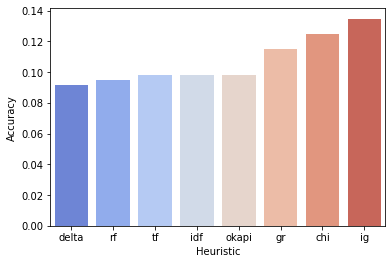

In [11]:
final_dataframe = final_dataframe.sort_values(by = ['Accuracy'])
_ = sns.barplot(final_dataframe.Heuristic, final_dataframe.Accuracy, palette = "coolwarm")

The information gain heuristic that performs best can be described as follows. Let $f(t,d)$ denote the number of
times a given path ($t$) appears in the collection of all paths ($d$). Let $C$ denote the set of classes, with an individual
class being denoted with $c$. The notation $t\ in d$ corresponds to a presence of a given type of path in the collection of all paths. With e.g., $P(t)$ we denote the probability of observing $t$. The information gain heuristic can finally be defined as follows
$$\textrm{ig} = f(t,d) \cdot \sum_{c \in C} \sum_{c' \in \{c, \neg c\}} \sum_{t' \in \{t, \neg t\}} \big ( P(t',c') \cdot \log \frac{P(t' \wedge c')}{P(t')P(c')} \big )$$